<h1>CONNECT 4 : IA com MCTS e Árvores de Decisão (ID3)</h1> 

Desenvolvido por Gustavo Valandro da Rocha, Marthina Oliveira de Castro, Yan de Oliveira Christiano Coelho

<h2>INTRODUÇÃO</h2>

Connect 4 é um jogo de estratégia para dois jogadores, cujo objetivo é alinhar quatro peças consecutivas da mesma cor, seja na vertical, horizontal ou diagonal. A disputa ocorre em um tabuleiro composto por sete colunas e seis linhas, onde os jogadores se alternam na inserção de suas peças, tentando formar sua sequência vencedora enquanto bloqueiam as jogadas do adversário.

Para desenvolver esse jogo, nosso grupo criou uma aplicação em Python, que oferece três modos distintos de jogo: <br>
- **Jogador vs Jogador** – dois participantes competem entre si.<br>
- **Jogador vs IA** – o jogador desafia uma inteligência artificial.<br>
- **IA vs IA** – duas inteligências artificiais se enfrentam autonomamente.<br>

Dessa forma, este notebook explora a aplicação da inteligência artificial no Connect 4, combinando simulação de partidas por meio de Monte Carlo Tree Search (MCTS) e aprendizagem supervisionada com Árvores de Decisão (ID3), aprimorando a tomada de decisões do sistema.

<h3>ESTRUTURA DO PROJETO</h3>

Armazenamento nos Diretórios:<br>
    - **ai**: códigos dos algoritmos de decisão MCTS e ID3; <br>
    - **game**: composta pela interface e códigos base do jogo, como lógica do jogo, tabuleiro e validações; <br>
    - **data**: dataset gerado usando MCTS; <br>
    - **scripts**: código para geração de dataset e árvore de decisão ID3; <br>
    - **models**: id3 model serializado em pickle. <br>



<h2> REGRAS DO JOGO </h2>

<h4>BIBLIOTECAS</h4>

In [4]:
import sys
import numpy as np
import pandas as pd
import time
import random
import math
import collections
import csv
import os
import typing


<h4>CONSTANTES</h4>

`ROWS (int)` : Número de linhas do tabuleiro (padrão: 6) <br>
`COLS (int)` : Número de colunas do tabuleiro (padrão: 7)<br>
`EMPTY (int)` : Posição vazia no tabuleiro 0 <br>
`PLAYER_X (int)` : Jogador 1 <br>
`PLAYER_O (int)` : Jogador 2 <br>
<br>

<h4>ATRIBUTOS</h4>

- `board`: Lista bidimensional  7×6 (COLS=7, ROWS=6), que armazena o estado do jogo, onde cada célula pode estar vazia (EMPTY) ou ocupada por PLAYER_X ou PLAYER_O.
- `current_player`: Controla o turno do jogador, alternando entre PLAYER_X e PLAYER_O.
- `winner`: Armazena o jogador vencedor (PLAYER_X, PLAYER_O ou None, se ainda não houver vencedor).
<br>

<h4>FUNÇÕES PRINCIPAIS DO JOGO</h4>

**Função __init__()**
- Inicializa um tabuleiro vazio, definindo todas as células como EMPTY.
- Define o jogador inicial como PLAYER_X.

**Função reset()**
- Limpa o tabuleiro, redefinindo todas as células para EMPTY.
- Reinicia o turno para PLAYER_X.

**Função valid_moves()**
- Retorna uma lista de colunas disponíveis (0-6) onde é possível jogar (topo da coluna deve estar vazio).
- Usada para determinar movimentos legais para jogadores ou IA.

**Funções make_move() e apply_move()**
- Coloca a peça do jogador atual na coluna especificada.
- Valida a jogada (verifica limites do tabuleiro e se a coluna não está cheia).
- Posiciona a peça na menor posição disponível da coluna (simulando gravidade).
- Alterna para o outro jogador após uma jogada válida.
- Atualiza o status do vencedor, verificando se a jogada resultou em uma vitória.

**Função check_win()**
- Verifica se algum jogador venceu, analisando padrões horizontais, verticais e diagonais.
- Retorna o jogador vencedor (PLAYER_X ou PLAYER_O) ou None, caso não haja vencedor.<br>

**Função is_full()**
- Determina se o tabuleiro está completamente preenchido (não há jogadas válidas restantes).<br>

**Função is_game_over()**
- Retorna True se houver um vencedor ou se o tabuleiro estiver completamente preenchido.<br>

**Função is_draw()**
- Retorna True se o tabuleiro estiver cheio e nenhum jogador tiver vencido.

<br>
<h5>FUNÇÕES DE DETECÇÃO DE VITÓRIA</h5>

**Função _four_horizontal()** : Verifica quatro peças consecutivas de um jogador nas linhas horizontais.<br>
**Função _four_vertical()** : Verifica quatro peças consecutivas de um jogador nas colunas verticais.<br>
**Função _four_diagonal()** : Verifica quatro peças consecutivas de um jogador nas duas direções diagonais (ascendente e descendente).<br>

<br>
<h5>FUNÇÕES UTILITÁRIAS</h5>

**Função copy()**
- Cria uma cópia profunda do tabuleiro para fins de simulação (usada em algoritmos de IA).
- Preserva todas as informações de estado, incluindo a configuração do tabuleiro, o jogador atual e o vencedor.<br>

**Função to_feature_vector()**
- Converte o tabuleiro 2D em uma lista 1D de 42 números inteiros (matriz 6×7).
- Utilizada em algoritmos de aprendizado de máquina, como ID3.

<br>
<h5>FUNÇÕES DE VISUALIZAÇÃO</h5>

**Função render()**
- Gera uma representação textual do tabuleiro, exibindo símbolos para cada célula.
- Mostra os números das colunas na parte inferior para referência do jogador.

**Função display()**
- Exibe o tabuleiro no console com o estado atual do jogo.
- Indica de quem é o próximo turno, caso o jogo ainda esteja em andamento.

**Função __str__()**
- Retorna uma representação em texto do tabuleiro (chama render()).



<h4>game.py</h4>

In [ ]:
class Game:
    def __init__(self):
        self.board = Board()
        self.player_names = {
            PLAYER_X: "Jogador X",
            PLAYER_O: "Jogador O"
        }
        self.current_game_active = True

    def set_player_names(self, player_x_name: str, player_o_name: str):
        if player_x_name:
            self.player_names[PLAYER_X] = player_x_name
        if player_o_name:
            self.player_names[PLAYER_O] = player_o_name

    def make_move(self, column: int) -> bool:
        self.board.apply_move(column)
        if self.board.is_game_over():
            self.current_game_active = False
        return True

    def get_valid_moves(self) -> List[int]:
        return self.board.valid_moves()

    def get_current_player_name(self) -> str:
        return self.player_names[self.board.current_player]

    def get_winner_name(self) -> Optional[str]:
        winner = self.board.get_winner()
        if winner and winner in self.player_names:
            return self.player_names[winner]
        return None

    def is_game_over(self) -> bool:
        return self.board.is_game_over()

    def is_draw(self) -> bool:
        return self.board.is_draw()

    def display_board(self):
        self.board.display()

    def is_active(self) -> bool:
        return self.current_game_active


<h4>board.py</h4>

In [ ]:
ROWS: int = 6
COLS: int = 7
EMPTY: int = 0
PLAYER_X: int = 1
PLAYER_O: int = 2

class Board:
    def __init__(self):
        self.board: list[list[int]] = [[EMPTY for _ in range(COLS)] for _ in range(ROWS)]
        self.current_player: int = PLAYER_X
        self.winner = None

    def valid_moves(self) -> list[int]:
        return [c for c in range(COLS) if self.board[0][c] == EMPTY]

    def apply_move(self, column: int):
        if column not in range(COLS):
            print(f"Coluna fora do intervalo 0‑6.")
        if self.board[0][column] != EMPTY:
            print(f"Coluna cheia – escolha outra.")

        for row in range(ROWS - 1, -1, -1):
            if self.board[row][column] == EMPTY:
                self.board[row][column] = self.current_player
                break

        self.current_player = PLAYER_X if self.current_player == PLAYER_O else PLAYER_O
        self.winner = self.check_win()

    def check_win(self) -> int | None:
        for player in (PLAYER_X, PLAYER_O):
            if (
                self._four_horizontal(player)
                or self._four_vertical(player)
                or self._four_diagonal(player)
            ):
                return player
        return None

    def is_full(self) -> bool:
        return all(self.board[0][c] != EMPTY for c in range(COLS))

    def is_game_over(self):
        return self.winner is not None or self.is_full()

    def is_draw(self):
        return self.is_full() and self.winner is None

    def get_winner(self) -> int | None:
        return self.winner

    def copy(self) -> "Board":
        new = Board()
        new.board = [row[:] for row in self.board]
        new.current_player = self.current_player
        new.winner = self.winner
        return new

    def to_feature_vector(self) -> list[int]:
        return [cell for row in self.board for cell in row]

    def render(self) -> str:
        symbols = {EMPTY: ".", PLAYER_X: "X", PLAYER_O: "O"}
        lines = [" ".join(symbols[cell] for cell in row) for row in self.board]
        header = " ".join(str(c) for c in range(COLS))
        return "\n".join(lines) + "\n" + header

    def display(self):
        print(self.render())
        if not self.is_game_over():
            player_name = "X" if self.current_player == PLAYER_X else "O"
            print(f"Vez do jogador {player_name}")

    def _four_horizontal(self, player: int) -> bool:
        for r in range(ROWS):
            consecutive = 0
            for c in range(COLS):
                consecutive = consecutive + 1 if self.board[r][c] == player else 0
                if consecutive == 4:
                    return True
        return False

    def _four_vertical(self, player: int) -> bool:
        for c in range(COLS):
            consecutive = 0
            for r in range(ROWS):
                consecutive = consecutive + 1 if self.board[r][c] == player else 0
                if consecutive == 4:
                    return True
        return False

    def _four_diagonal(self, player: int) -> bool:
        for r in range(ROWS - 3):
            for c in range(COLS - 3):
                if all(self.board[r + i][c + i] == player for i in range(4)):
                    return True
        for r in range(3, ROWS):
            for c in range(COLS - 3):
                if all(self.board[r - i][c + i] == player for i in range(4)):
                    return True
        return False


<h4>ui.py</h4>

In [6]:
import os
import time
from typing import Optional

class UI:
    def __init__(self, game):
        self.game = game

    def clear_screen(self):
        os.system('cls' if os.name == 'nt' else 'clear')

    def print_welcome(self):
        self.clear_screen()
        print("=" * 56)
        print("       BEM-VINDO AO JOGO CONNECT FOUR (CONECTA 4)       ")
        print("=" * 56)
        print("\nRegras:")
        print("1. Dois jogadores alternam entre colocar peças no tabuleiro")
        print("2. O objetivo é conectar 4 peças na horizontal, vertical ou diagonal")
        print("3. O primeiro jogador a conectar 4 peças vence")
        print("4. Se o tabuleiro ficar cheio sem vencedor, é um empate")
        print("\nControles:")
        print("- Digite o número da coluna (0-6) para colocar uma peça")

    def get_player_names(self, mode: int):
        self.clear_screen()
        print("Configuração dos Jogadores\n")
        if mode == 1:
            player_x = input("Nome do Jogador X: ")
            player_o = input("Nome do Jogador O: ")
        elif mode == 2:
            player_x = input("Nome do Jogador X: ")
            player_o = "Computador"
        else:
            player_x = "Computador 1"
            player_o = "Computador 2"

        self.game.set_player_names(player_x, player_o)

    def get_game_mode(self) -> int:
        self.clear_screen()
        print("Selecione o modo de jogo:")
        print(" 1 - Humano vs Humano")
        print(" 2 - Humano vs Computador")
        print(" 3 - Computador vs Computador")
        while True:
            choose = input("Modo [1/2/3]: ").strip()
            if choose in ("1", "2", "3"):
                return int(choose)
            print("Opção inválida. Digite 1, 2 ou 3.")

    def get_move(self) -> Optional[int]:
        current_player_name = self.game.get_current_player_name()
        valid_moves = self.game.get_valid_moves()

        while True:
            move_str = input(f"\n{current_player_name}, escolha uma coluna (0-6): ")
            if not move_str.isdigit():
                print("Entrada inválida. Digite um número entre 0 e 6")
                continue
            column = int(move_str)
            if column not in valid_moves:
                print(f"Coluna {column} não está disponível. Escolha uma das colunas: {valid_moves}")
                continue
            return column

    def show_game_result(self):
        if self.game.is_game_over():
            if self.game.is_draw():
                print("\nO jogo terminou em empate!")
            else:
                winner_name = self.game.get_winner_name()
                print(f"\nParabéns! {winner_name} venceu!")

    def display_game(self):
        self.clear_screen()
        print(f"{self.game.player_names[1]} (X) vs {self.game.player_names[2]} (O)\n")
        self.game.display_board()
        if self.game.is_game_over():
            self.show_game_result()

    def show_move_error(self, error_message: str):
        print(f"Erro: {error_message}")
        time.sleep(1.5)


<h2>IMPLEMENTAÇÃO DO MONTE CARLO TREE SEARCH (MCTS)</h2>

O algoritmo constrói uma árvore de possibilidades em tempo real, executando simulações para estimar o valor de cada movimento para escolhe o movimento com maior valor esperado.


<h4>Classe Node</h4> 

A classe `Node` representa um **nó** na árvore de busca do MCTS. Cada nó corresponde a um estado do jogo e guarda as informações necessárias para o algoritmo realizar sua exploração.

Atributos:
- **board**: estado atual do jogo (`Board`);
- **parent**: nó pai (anterior);
- **move**: movimento (coluna) que gerou esse nó;
- **children**: lista de filhos (possíveis futuros estados);
- **wins**: número de vitórias registradas a partir deste nó;
- **visits**: número de vezes que esse nó foi visitado;
- **untried_moves**: lista de movimentos ainda não expandidos.

<h4>Classe MCTS</h4>

Controla a execução do algoritmo **Monte Carlo Tree Search**. Implementa os 4 passos principais: Seleção, Expansão, Simulação (Rollout) e Backpropagação.

Atributos:
- **iterations**: número de simulações por jogada;
- **exploration_weight**: parâmetro para o cálculo do UCT;
- **max_children**: limite de filhos expandidos por nó (None para sem limite).


Função `best_move(root_board)` executa o algoritmo MCTS a partir do estado atual do tabuleiro e retorna a **melhor jogada** (coluna).

Segue as seguintes etapas:

##### 1. Seleção
Percorre a árvore do nó raiz até um nó folha, escolhendo os filhos com maior UCT, até encontrar:
- Um nó com movimentos ainda não expandidos;
- Ou um nó folha.

##### 2. Expansão
Caso existam movimentos ainda não explorados:
- Escolhe um movimento aleatório;
- Cria novo nó filho com o estado resultante;
- Adiciona esse filho à árvore.

##### 3. Simulação (Rollout)
Executa uma simulação do jogo até o final:
- Usa uma heurística simples para verificar se há movimento que **vence imediatamente**;
- Caso não haja, escolhe uma jogada **aleatória**.
  


In [ ]:
_rollout(self, board):

for m in moves:
    temp = board.copy()
    temp.apply_move(m)
    if temp.get_winner() == player:
        return player

##### 4. Retropropagação (Backpropagation)
Propaga o resultado da simulação até a raiz atualizando estatísticas dos nós ancestrais:
- Incrementa `visits` para todos os nós no caminho;
- Se o jogador original venceu, incrementa `wins`;
- Se foi empate, adiciona 0.5 às vitórias.


**Rollout com Heurística de Vitória Imediata**
- Antes de fazer movimentos aleatórios, o algoritmo verifica se há alguma jogada que leve à vitória direta, reduzindo a aleatoriedade dos rollouts e guia a árvore para caminhos com maior probabilidade de vitória — evita simulações desnecessárias. Assim, encurtando a simulação e aumentando a precisão da estimativa de valor daquele caminho.

**Uso de UCT para Seleção**
- A função `uct_select_child()` utiliza a fórmula UCT (Upper Confidence Bound for Trees) para selecionar o próximo filho a ser visitado.
- Isso equilibra duas forças opostas:
  - **Exploration:** testar novos caminhos ainda pouco explorados que podem esconder boas oportunidades;
  - **Exploitation:** continuar explorando caminhos que já provaram ser bons (muitas vitórias).

Assim, a função `uct_select_child(exploration_weight)` seleciona o filho com maior valor de UCT (Upper Confidence Bound) levando em consideração as vitórias do filho, as visitas ao filho, as visitas ao pai e o prâmetro de exploração (*exploration_weight* - ajustável para adaptar a agressividade da busca). Com o UCT, o algoritmo se autoajusta dinamicamente durante as simulações, focando onde há maior potencial de descoberta ou desempenho.
Se o valor de exploration_weight for alto, o MCTS tende a experimentar mais caminhos novos. 
Se for baixo, o MCTS tende a confiar nos caminhos já bem explorados.

<h4>mcts.py</h4>

In [ ]:
import math
import random
from typing import Optional

class Node:
    def __init__(self, board: Board, parent: Optional["Node"] = None, move: Optional[int] = None):
        self.board = board
        self.parent = parent
        self.move = move
        self.children: list[Node] = []
        self.wins: float = 0.0
        self.visits: int = 0
        self.untried_moves: list[int] = board.valid_moves()

    def uct_select_child(self, exploration_weight: float) -> "Node":
        log_parent = math.log(self.visits)
        best = max(
            self.children,
            key=lambda c: (c.wins / c.visits) + exploration_weight * math.sqrt(log_parent / c.visits)
        )
        return best

class MCTS:
    def __init__(
        self,
        iterations: int = 1000,
        exploration_weight: float = math.sqrt(2),
        max_children: Optional[int] = None
    ):
        self.iterations = iterations
        self.exploration_weight = exploration_weight
        self.max_children = max_children

    def best_move(self, root_board: Board) -> int:
        root = Node(root_board.copy())
        player = root_board.current_player

        for _ in range(self.iterations):
            node = root
            state = root_board.copy()

            while True:
                can_expand = (
                    node.untried_moves and
                    (self.max_children is None or len(node.children) < self.max_children)
                )
                if can_expand or not node.children:
                    break
                node = node.uct_select_child(self.exploration_weight)
                state.apply_move(node.move)

            if node.untried_moves and (
                self.max_children is None or len(node.children) < self.max_children
            ):
                m = random.choice(node.untried_moves)
                state.apply_move(m)
                node.untried_moves.remove(m)
                child = Node(state.copy(), parent=node, move=m)
                node.children.append(child)
                node = child

            winner = self._rollout(state.copy())

            while node:
                node.visits += 1
                if winner == player:
                    node.wins += 1
                elif winner is None:
                    node.wins += 0.5
                node = node.parent

        best_child = max(root.children, key=lambda c: c.visits)
        return best_child.move

    def _rollout(self, board: Board) -> Optional[int]:
        while not board.is_game_over():
            moves = board.valid_moves()
            player = board.current_player
            for m in moves:
                temp = board.copy()
                temp.apply_move(m)
                if temp.get_winner() == player:
                    return player
            board.apply_move(random.choice(moves))
        return board.get_winner()


<h2>GERAÇÃO DO DATASET PARA CONNECT 4</h2>

Para a geração do segundo dataset proposto no projeto *`dataset_generator.py`*, desenvolvemos duas funções: 
- `simulate_game`: simula uma partida do jogo usando o algoritmo Monte Carlo Tree Search, registrando o vetor de estado do tabuleiro e movimento escolhido pelo MCTS, com a melhor jogada naquela configuração do tabuleiro. A cada jogada, ela registra:

    - O vetor com **42 posições**, representando o estado atual do tabuleiro (0 para vazio, 1 para jogador X, 2 para jogador O).
    + O **movimento** selecionado pelo MCTS, após um número definido de simulações (índice da coluna escolhida, de 0 a 6).
     <br>

      
- `generate_dataset`: gera partidas (`simulate_game`) em paralelo (usando a biblioteca multiprocessing) para criação de um arquivo CSV com 43 colunas (42 posições do tabuleiro + 1 movimento escolhido pelo MCTS) e a quantidade de jogadas por cada linha. Dessa forma, cada linha do dataset conterá:

O tamanho do dataset depende do número de partidas geradas (`n_games`). No presente projeto, definimos `n_games=1000`, resultando em 9806 linhas (média aproximada de 10 jogadas por partida). Além disso, definimos como 10.000 o número de iterações (`iterations`), para que as decisões sejam mais inteligentes, ou seja, apesar do processo ficar mais lento, garantimos a qualidade do movimento escolhido; posto que, o número de iterações corresponde a quantidade de simulações que o MCTS faz para escolher a próxima jogada em cada estado do jogo.

Para validarmos os dados obtidos, plotamos um gráfico para análise das posições preferenciais do algoritmo MCTS, o qual tende a escolher a posição central. Através da classe *`check.py`* obtivemos o seguinte gráfico:


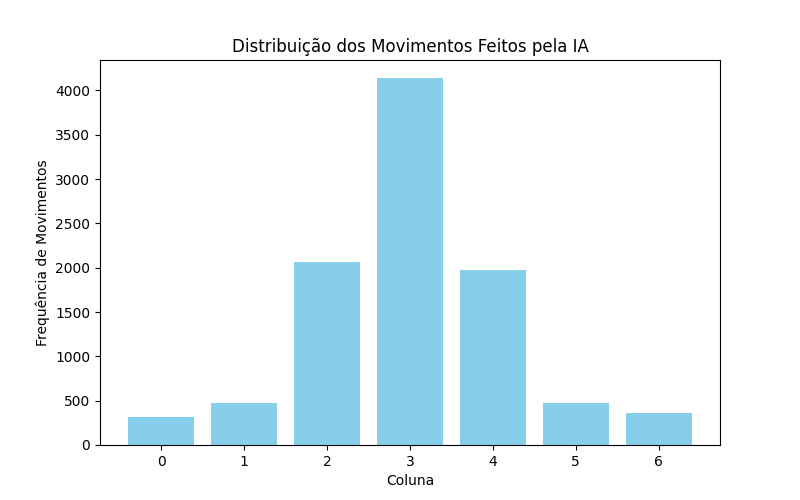

O gráfico apresentado mostra claramente uma distribuição não uniforme dos movimentos escolhidos pelo algoritmo MCTS durante a geração do dataset de treinamento. 
- Forte Preferência pela Coluna Central (3): Com aproximadamente 4100 movimentos, a coluna 3 (central) é escolhida com mais do que o dobro da frequência das colunas adjacentes.
- Distribuição Simétrica: Existe uma simetria aproximada em torno da coluna central, com as colunas 2 e 4 tendo frequências similares (cerca de 2000 movimentos cada).
- Frequência Decrescente nas Bordas: As colunas 0, 1, 5 e 6 (mais periféricas) são escolhidas com frequência significativamente menor (entre 300-500 movimentos).

Esta distribuição reflete nos princípios estratégicos do jogo Connect Four, como a vantagem posicional da coluna central, visto que uma peça na coluna central tem mais opções para formar sequências em mais combinações vencedoras (horizontal, vertical e ambas as diagonais), além de permitir maior flexibilidade estratégica de ataque, posto que tem potencial para formar parte de 4 linhas de ataque diferentes, enquanto uma peça na borda tem apenas 2. A segunda preferência pelas colunas 2 e 4 é referente ao segundo melhor posicionamento estratégico, pois criam ameaças diagonais menos óbvias. Por fim, a baixa frequência nas colunas periféricas revela que estas posições oferecem menos oportunidades para formar sequências vencedoras, sendo usadas em situações específicas, como defesa.

Analisando e comparando o gráfico plotado com as táticas de jogo, é possível validar o dataset gerado. Assim, o dataset composto pelos pares (estado, movimento) treinará a árvore de decisão usando o algoritmo MCTS como especialista. O MCTS descobriu independentemente princípios estratégicos de Connect Four através de simulação e exploração, e treinará a árvore de decisão ID3 para adotar estratégias semelhantes. 

A  árvore de decisão ID3 treinada com estes dados provavelmente herdará esta tendência estratégica de escolha das posições centrais. No entanto, como as posições periféricas aparecem com menos frequência, ela pode não reconhecer essas jogadas como boas opções durante uma partida. Podendo levar a decisões menos otimizadas, pois a árvore aprendeu a favorecer jogadas no centro do tabuleiro, mesmo quando uma jogada na lateral poderia ser melhor. 

<h4>dataset_generator.py</h4>

In [ ]:
def generate_game(iterations: int, max_children: Optional[int]) -> List[List[int]]:
    engine = MCTS(iterations=iterations, max_children=max_children)
    game = Game()
    records: List[List[int]] = []

    while game.is_active():
        state = game.board.to_feature_vector()
        move = engine.best_move(game.board)
        records.append(state + [move])
        game.make_move(move)

    return records

def generate_dataset(
    n_games: int = 1000,
    iterations: int = 10000,
    max_children: Optional[int] = None,
    out_file: str = "connect4_dataset.csv"
) -> None:
    path = os.path.join(DATA_DIR, out_file)

    with open(path, "w", newline="") as f:
        writer = csv.writer(f)
        header = [f"cell_{i}" for i in range(42)] + ["move"]
        writer.writerow(header)

    for idx in range(1, n_games + 1):
        records = generate_game(iterations, max_children)
        with open(path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(records)

        if idx % 100 == 0 or idx == n_games:
            now = time.strftime("%H:%M:%S")
            print(f"[{now}] Jogos completados: {idx}/{n_games}")

    print(f"Dataset salvo em: {path}")

if __name__ == "__main__":
    generate_dataset(n_games=1000, iterations=10000, max_children=None)


<h2>ÁRVORE DE DECISÃO COM ALGORITMO ID3</h2>

Para treinar uma árvore de decisão com dois conjuntos de dados — o `iris.csv` e o dataset gerado por `dataset_generator.py` — foi desenvolvida a classe `ID3Tree`. Essa classe encapsula toda a lógica necessária para construir e utilizar uma árvore de decisão com o algoritmo ID3.

Há dois conceitos fundamentais para o ID3: a entropia e o ganho de informação. A função `entropy(self, y)` calcula a entropia do conjunto em cada nó,  medindo a impureza do conjunto de dados. Quanto menor a entropia, mais homogêneo é o conjunto. Enquanto a função `info_gain(self, y, y_left, y_right)` calcula o ganho de informação, ou seja, o quanto a entropia diminui após uma divisão. Assim, o atributo que maximiza a redução da entropia (ganho de informação) é escolhido para dividir o nó, permitindo escolher o melhor atributo para dividir os dados.

A função `best_split(self, X, y)` percorre todos os atributos e seus valores possíveis para encontrar a melhor divisão dos dados. Para cada valor, os dados são separados em dois grupos:
- Grupo da esquerda: onde o atributo é igual ao valor.
- Grupo da direita: onde o atributo é diferente do valor.
Depois, calcula-se o ganho de informação dessa divisão. A melhor divisão será aquela que produzir o maior ganho de informação.

A árvore foi projetada para realizar apenas divisões binárias (esquerda e direita), o que simplifica o controle de profundidade usando o parâmetro opcional `max_depth`. Esse parâmetro limita a profundidade da árvore, ajudando a evitar overfitting (quando o modelo se ajusta demais aos dados de treinamento e perde generalização).

A função `build_tree(self, X, y, depth=0)` constrói a árvore de forma recursiva, utilizando as melhores divisões. A recursão para nos seguintes casos:
- Todos os exemplos em um nó pertencem à mesma classe (folha).
- A profundidade máxima (max_depth) foi atingida.
- Não há mais divisões com ganho de informação positivo.
Nesses casos, o nó se torna uma folha com o rótulo mais frequente. Quando uma divisão é feita, o nó é representado como um dicionário com a chave sendo uma tupla (atributo, valor), e os valores sendo dois novos ramos: 'left' e 'right'.


Com a classe ID3Tree implementada, treinamos a árvore com o dataset `iris.csv` e criamos o modelo treinado com o dataset `connect4_dataset.csv` no arquivo `id3_model.pkl`.

<h4>id3.py</h4>

In [ ]:
from collections import Counter
import numpy as np

class ID3Tree:
    def __init__(self, max_depth=None):
        self.tree = None
        self.max_depth = max_depth

    def entropy(self, y):
        counts = Counter(y)
        total = len(y)
        entropy_value = 0
        for count in counts.values():
            p = count / total
            entropy_value += -p * np.log2(p) if p > 0 else 0
        return entropy_value

    def info_gain(self, y, y_left, y_right):
        p = len(y_left) / len(y)
        gain = self.entropy(y) - (p * self.entropy(y_left) + (1 - p) * self.entropy(y_right))
        return gain

    def best_split(self, X, y):
        best_gain = 0
        best_attr = None
        best_splits = None 
        for col in X.columns:
            values = X[col].unique()
            for val in values:
                left_mask = X[col] == val
                right_mask = ~left_mask
                y_left, y_right = y[left_mask], y[right_mask]
                gain = self.info_gain(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    best_attr = (col, val)
                    best_splits = (X[left_mask], y[left_mask], X[right_mask], y[right_mask])
        return best_attr, best_splits

    def build_tree(self, X, y, depth=0):
        if len(set(y)) == 1:
            return y.iloc[0]
        if X.empty or (self.max_depth is not None and depth >= self.max_depth):
            return y.mode()[0]
        attr, splits = self.best_split(X, y)
        if attr is None:
            return y.mode()[0]
        left_branch = self.build_tree(splits[0], splits[1], depth + 1)
        right_branch = self.build_tree(splits[2], splits[3], depth + 1)
        return {attr: {'left': left_branch, 'right': right_branch}}

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        attr, branches = list(tree.items())[0]
        value = x[attr[0]]
        if value == attr[1]:
            return self.predict_one(x, branches['left'])
        else:
            return self.predict_one(x, branches['right'])

    def predict(self, X):
        return X.apply(lambda x: self.predict_one(x, self.tree), axis=1)


<h2>ÁRVORE DE DECISÃO COM DATASET IRIS</h2>

Antes de classificar o dataset Iris implementando a árvore de decisão ID3, foi necessário discretizar os valores numéricos do dataset disponibilizado em 3 categorias: 'small', 'medium' e 'large', posto que o algoritmo ID3 funciona melhor com atributos categóricos.

Decidimos usar discretização por frequência igual (`equal_frequency_discretization`), dividindo os dados em bins com aproximadamente o mesmo número de amostras em cada um. Segundo o que pesquisamos, esta técnica garante o bom funcionamento do algoritmo ID3, por realizar uma distribuição balanceada das amostras em cada categoria implementando um algoritmo simples.

Após a discretização, é aplicada a divisão em treino (80%) e teste (20%), dessa forma, é usada a função *sample()* do pandas, para selecionar aleatoriamente 80% das linhas do dataset discretizado, e a função *drop()* para remover todas as linhas cujos indices estão na amostrada treinada. Assim, resultando em um dataset contendo apenas as linhas que não foram selecionadas para o conjunto de treino, incluíndo os 20% restantes das linhas.

Para classificar os dados discretizados obtidos a partir do dataset Iris disponibilizado, implementamos a árvore de decisão aplicando o algoritmo ID3 `id3.py`, construindo a árvore recursivamente selecionando o melhor atributo em cada passo. Assim, se todas as amostras pertencem à mesma classe, cria um nó folha com essa classe e se não há mais atributos para dividir, cria um nó folha com a classe majoritária. Para outros casos, seleciona o atributo com maior ganho de informação e cria subárvores para cada valor possível desse atributo. A implementação segue o padrão esperado do algoritmo, com os casos de parada adequados (todas as amostras pertencem à mesma classe ou não há mais atributos para dividir).

Portanto, com 90% de acurácia, o código implementado constrói uma árvore de decisão usando o algoritmo ID3 para classificar o dataset Iris, servindo como um "aquecimento" antes de aplicar árvores de decisão ao dataset gerado usando MCTS para Connect 4.

<h4>iris_decision_tree.py</h4>

In [ ]:
def equal_frequency_discretization(df, columns, bins=3):
    result = df.copy()
    for col in columns:
        result[col] = pd.qcut(result[col], q=bins, labels=['low', 'mid', 'high'])
    return result

if __name__ == "__main__":
    df = pd.read_csv("../data/iris.csv")
    features = ['sepallength', 'sepalwidth', 'petallength', 'petalwidth']
    target = 'class'

    df_discretized = equal_frequency_discretization(df, features, bins=3)

    train = df_discretized.sample(frac=0.8, random_state=1)
    test = df_discretized.drop(train.index)

    tree = ID3Tree(max_depth=None)
    tree.fit(train[features], train[target])
    tree.predict(test[features])

    preds = tree.predict(test[features])

    accuracy = (preds == test[target]).mean()
    print(f"Acurácia: {accuracy:.2%}")


<h2>TREINAMENTO E AVALIAÇÃO DA ÁRVORE DE DECISÃO PARA CONNECT 4</h2>

Este script treina e avalia uma árvore de decisão utilizando o algoritmo ID3 para o jogo Connect Four, a partir dos dados gerados por MCTS. O objetivo é transformar a estratégia aprendida pelo MCTS em uma árvore de decisão eficiente e reutilizável, capaz de tomar decisões rápidas durante o jogo. Para isso, implementamos o algoritmo ID3 e usamos a biblioteca `pickle` para salvar (serializar) o modelo treinado em disco.

Primeiramente, os dados do jogo do dataset são organizados em:
- X: atributos de entrada — todas as colunas exceto a última, representando o estado do tabuleiro.
- y: rótulo ou saída — a última coluna, que indica o resultado do jogo.

Assim como no treino com o dataset `iris.csv`, foi aplicada a divisão em treino (80%) e teste (20%) e para garantir que as alterações feitas em um conjunto não afetem o outro, usamos o método `.copy()` para criar cópias independentes, evitando problemas com referências compartilhadas e vazamento de dados entre treino e teste.

Definimos o valor max_depth=20 para a profundidade máxima da árvore para equilibrar a captura de padrões mais complexos no jogo com a redução do risco de overfitting, melhorando a capacidade de generalização do modelo.

Após o treinamento, o modelo é serializado com a biblioteca `pickle`, permitindo que ele seja reutilizado futuramente, sem necessidade de retreinamento. Isso é especialmente útil para modelos complexos ou que levam muito tempo para serem treinados.

<h4>train_id3_connect4.py</h4>

In [ ]:
dataset_path = os.path.join("../data/connect4_dataset.csv")

data = pd.read_csv(dataset_path)
print(data.head())
print(data.info())

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

treino_frac = 0.8
train_size = int(len(X) * treino_frac)

X_train = X[:train_size].copy()
X_test = X[train_size:].copy()
y_train = y[:train_size].copy()
y_test = y[train_size:].copy()

if isinstance(X_train, pd.DataFrame) == False:
    X_train = pd.DataFrame(X_train, columns=[f'cell_{i}' for i in range(42)])
if isinstance(X_test, pd.DataFrame) == False:
    X_test = pd.DataFrame(X_test, columns=[f'cell_{i}' for i in range(42)])
if isinstance(y_train, pd.Series) == False:
    y_train = pd.Series(y_train)
if isinstance(y_test, pd.Series) == False:
    y_test = pd.Series(y_test)

print(f'Tamanho do conjunto de treino: {len(X_train)}')
print(f'Tamanho do conjunto de teste: {len(X_test)}')

id3_tree = ID3Tree(max_depth=20)
id3_tree.fit(X_train, y_train)

y_pred = id3_tree.predict(X_test)

accuracy = np.mean(y_pred == y_test) * 100
print(f'Acurácia da Árvore ID3: {accuracy:.2f}%')

model_path = os.path.join("../ai/models/id3_model.pkl")

with open(model_path, "wb") as file:
    pickle.dump(id3_tree, file)
print("Modelo ID3 salvo com sucesso!")

<h2>EXPERIMENTOS E RESULTADOS</h2>

Em partidas entre humanos e MCTS, o algoritmo demonstrou ótimo desempenho, respondendo de forma eficaz mesmo a jogadas novas ou estratégias pouco convencionais. Isso se deve à sua capacidade de simular várias possibilidades futuras a cada turno, o que o torna adaptável e estrategicamente avançado. Como o modelo não depende de padrões fixos de treinamento, consegue reagir de forma inteligente mesmo diante de movimentos imprevisíveis.

Em confrontos entre algoritmos, o MCTS foi claramente superior ao ID3. Quando começou jogando, o MCTS venceu 93% das partidas, e mesmo jogando em segundo, manteve um alto desempenho com 69% de vitórias. Isso demonstra sua capacidade de adaptação e planejamento, pois simula vários cenários possíveis antes de tomar uma decisão, ao contrário da árvore de decisão, que apenas replica padrões aprendidos com o MCTS e não realiza simulações.

Assim, apesar de mais complexo e menos veloz, o MCTS é preferível quando se busca jogabilidade inteligente e adaptativa. Cada abordagem tem seu valor: ID3 funciona bem em aplicações com poucos recursos ou tempo limitado, enquanto o MCTS é ideal para partidas mais complexas e dinâmicas, onde é preciso antecipar as jogadas do oponente.

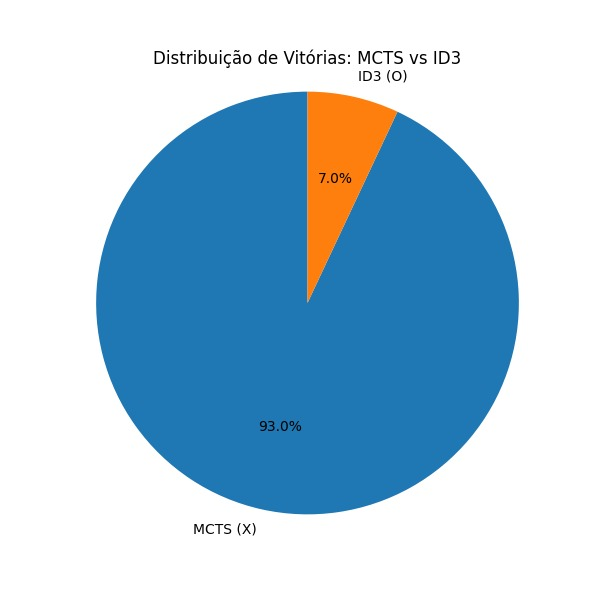 

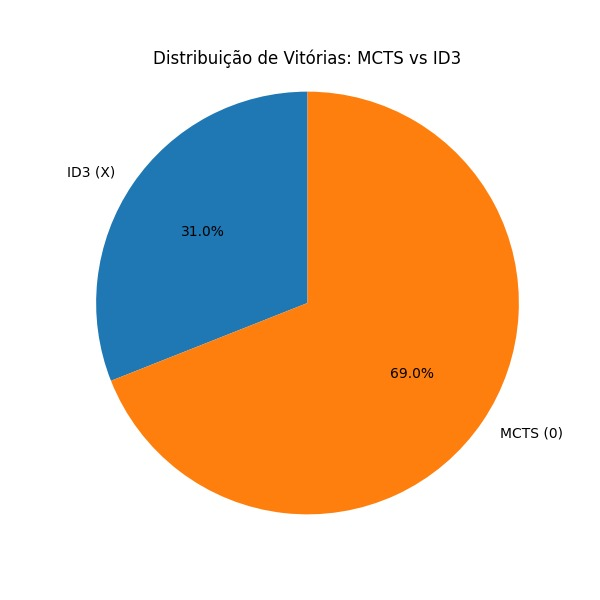

<h2>CONCLUSÃO</h2>

O MCTS demonstrou excelente desempenho ao simular diversos caminhos possíveis do jogo, adaptando-se dinamicamente às ações do oponente. Por outro lado, a árvore ID3 se mostrou eficiente em termos de velocidade e simplicidade, tomando decisões imediatas com base em padrões aprendidos, embora limitada por não conseguir responder a situações inéditas. Em cenários de confronto direto, o MCTS obteve resultados significativamente superiores, destacando-se como a melhor escolha para ambientes interativos e imprevisíveis como o Connect-4.

Durante o desenvolvimento, também percebemos que a qualidade dos dados e a discretização do tabuleiro são fatores determinantes para a performance da árvore de decisão. Por exemplo, embora colunas centrais sejam geralmente mais vantajosas, é importante que o modelo também reconheça contextos em que jogadas nas colunas periféricas são estratégicas. Isso exige uma discretização mais refinada dos estados do jogo, de forma a capturar nuances posicionais e contextuais que contribuam para uma acurácia mais realista e eficaz nas previsões da IA.